<a href="https://colab.research.google.com/github/lobiouni/Missouri_Reservoirs/blob/main/match_MU_to_DNR_WBID_7630.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from shapely import geometry, ops
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry.multipolygon import MultiPolygon
from shapely.ops import cascaded_union
from shapely.ops import unary_union

from shapely import intersection
from shapely import intersects
from shapely import concave_hull
from shapely import difference, within, contains

Index(['FID', 'TBLE_NAME', 'NHD', 'METADATA', 'STNDRD_ID', 'WBID', 'WBID_TXT',
       'WATER_BODY', 'WB_CLS', 'DS_COUNTY', 'US_COUNTY', 'HUC_8', 'SIZE_',
       'UNIT', 'LEGAL_DS', 'AQL_USE', 'CDF_USE', 'DWS_USE', 'IND_USE',
       'IRR_USE', 'LWW_USE', 'SCR_USE', 'WBCA_USE', 'WBCB_USE', 'HHP_USE',
       'NNC', 'PERM_ID', 'REACHCODE', 'Shape__Area', 'Shape__Length',
       'geometry'],
      dtype='object')

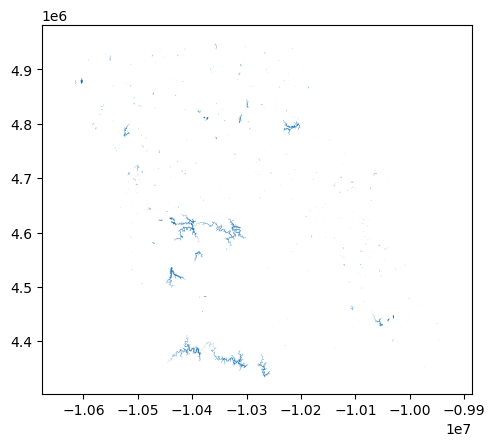

In [ ]:
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

MO_DNR = gpd.read_file("MO_2020_WQS_Lake_Classification_and_Use.geojson", driver='GeoJSON')
MO_DNR = MO_DNR.drop(columns="EVENTDAT").drop(columns="REACHSMDAT").round(0)
MO_DNR = MO_DNR[MO_DNR["WATER_BODY"] !="100K Extent-Remaining Lakes"]
MO_DNR = MO_DNR.to_crs(crs=3857)
MO_DNR.plot()
MO_DNR.keys()

## Read in MU data, convert lat lon columns to geometry

In [ ]:
MU = pd.read_csv('waterBody.csv')
MU

,waterBodyID,MULakeNumber,waterBody,waterBodyLatitude,waterBodyLongitude,waterBodyDesc,countyID,countryID,ecoregionID,stateID,waterBodyTypeID,MDNRNameID,primarySLAP19,damHeightM,volumeM3,surfAreaHA,watershedAreaHA,notes
0,1,1,Glover,38.8476,-91.8876,NaN,NaN,187,2.0,29,2,NaN,NaN,10.1,460088.0,7.8,1489.0,NaN
1,2,2,Pinnacle,38.8258,-91.4197,NaN,NaN,187,2.0,29,2,NaN,NaN,14.9,3066431.0,38.4,1900.1,NaN
2,3,3,Bowling Green (East),39.3416,-91.1530,NaN,NaN,187,2.0,29,2,NaN,yes,22.3,1739207.0,8.9,337.0,NaN
3,4,4,Bowling Green (West),39.3423,-91.1611,NaN,NaN,187,2.0,29,2,NaN,NaN,18.6,1303788.0,18.2,10.3,NaN
4,5,5,Lincoln,39.0203,-90.9217,NaN,NaN,187,2.0,29,2,NaN,yes,21.0,1894625.0,12.8,404.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,370,461,See Tal,38.6881,-91.4368,NaN,36.0,187,NaN,29,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355,371,462,Tilles Park,38.6222,-90.3636,NaN,98.0,187,NaN,29,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356,372,463,McKee Pond,38.6710,-92.2592,NaN,10.0,187,NaN,29,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357,373,464,Cedar (Randolph),39.3925,-92.4234,NaN,86.0,187,NaN,29,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

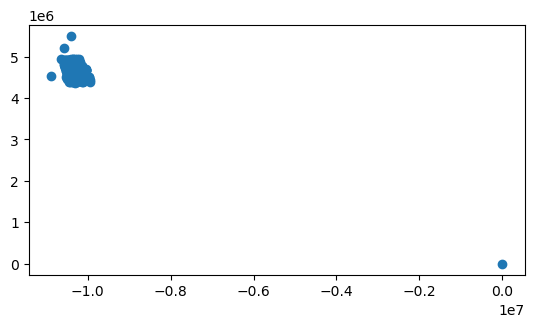

In [ ]:
MU[MU.waterBody != 'Field Blank']
MU[MU.waterBody != 'Cheney'] ## In Kansas
MU[MU.waterBody != 'Lake Thunderhead'] ## In Minnesota
geo_df = gpd.GeoDataFrame(MU, geometry=gpd.points_from_xy(MU.waterBodyLongitude, MU.waterBodyLatitude) ).set_crs(4326)
geo_df = geo_df.to_crs(crs=3857)
geo_df.plot()

In [ ]:
distances = np.zeros([len(geo_df), len(MO_DNR)])

for i in range(0,len(geo_df)):
    for j in range(0,len(MO_DNR)):
        distances[i,j] = geo_df.iloc[i].geometry.distance(MO_DNR.iloc[j].geometry.centroid)

idx = np.argmin(distances, axis=1)
distance  = np.min(distance, axis=1)


In [ ]:

MO_WATERBODY = MO_DNR.iloc[idx]['WATER_BODY']
MO_WBID = MO_DNR.iloc[idx]['WBID']
MO_WATERBODY.index = geo_df.index
MO_WBID.index = geo_df.index
distance = pd.Series(distance, index =  geo_df.index)

final_MU = pd.concat([geo_df, MO_WATERBODY, MO_WBID, distance], axis=1)
final_MU.to_csv("MU v DNR.csv")
final_MU

,waterBodyID,MULakeNumber,waterBody,waterBodyLatitude,waterBodyLongitude,waterBodyDesc,countyID,countryID,ecoregionID,stateID,...,primarySLAP19,damHeightM,volumeM3,surfAreaHA,watershedAreaHA,notes,geometry,WATER_BODY,WBID,0
0,1,1,Glover,38.8476,-91.8876,NaN,NaN,187,2.0,29,...,NaN,10.1,460088.0,7.8,1489.0,NaN,POINT (-10228880.842 4699865.031),Glover Spring Lake,7177,460.180684
1,2,2,Pinnacle,38.8258,-91.4197,NaN,NaN,187,2.0,29,...,NaN,14.9,3066431.0,38.4,1900.1,NaN,POINT (-10176794.452 4696749.546),Pinnacle Lake,7249,732.487334
2,3,3,Bowling Green (East),39.3416,-91.1530,NaN,NaN,187,2.0,29,...,yes,22.3,1739207.0,8.9,337.0,NaN,POINT (-10147105.544 4770721.634),Bowling Green Reservoir,7004,483.798731
3,4,4,Bowling Green (West),39.3423,-91.1611,NaN,NaN,187,2.0,29,...,NaN,18.6,1303788.0,18.2,10.3,NaN,POINT (-10148007.232 4770822.392),Old Lake,7003,165.847576
4,5,5,Lincoln,39.0203,-90.9217,NaN,NaN,187,2.0,29,...,yes,21.0,1894625.0,12.8,404.2,NaN,POINT (-10121357.346 4724579.791),Lake Lincoln,7049,574.523476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,370,461,See Tal,38.6881,-91.4368,NaN,36.0,187,NaN,29,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-10178698.016 4677092.539),See Tal Lake,7253,137.323107
355,371,462,Tilles Park,38.6222,-90.3636,NaN,98.0,187,NaN,29,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-10059229.938 4667698.543),Simpson Park Lake,7502,14910.423771
356,372,463,McKee Pond,38.6710,-92.2592,NaN,10.0,187,NaN,29,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-10270247.165 4674654.116),Lake Champetra,7181,3170.065341
357,373,464,Cedar (Randolph),39.3925,-92.4234,NaN,86.0,187,NaN,29,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-10288525.825 4778050.794),Rothwell Lake,7164,6098.810673


In [ ]:
final_MU

In [ ]:
idx1 = np.argmin(distance_to_shore, axis=1)
idx2 = np.argmax(within_boolean, axis=1)
idx = idx2
np.copyto(idx, idx1, where=idx== 0)
print(idx)

[176 248   3   2  48  53  55 254 242 240 185 184 306 257 303 469 477 478
 300 264 266 265 326 272 517 517 310 339 334 325 321 322 318 324 324 323
 330 298 293 199 488 181 182 157 172 165 170 167 149 153 152  12  10  18
  25  14 414  41  33  50 492 186  92 102 101  90  96 213 217  71  76  85
  86  66  63 449 123 122 121 117 114 108 131 130 435 137 135 206 207 233
 237 234 354 235 236 311 313 313 314 316 315 319 238 244 281 280 320 286
 287 470 191  23  28 100 179 212 148 211 189  19  35   8  40  39  22  38
 151  17 150 103 127 160 159 119  13 105 404  32 332 356 204 188 481  70
 192 358 383 383 231 396 111 145 389 372 377 401 381 376 519  75 366 400
   7 385 197 384 329 363 347 228  57 387 146 489  81 110 208  56  82 163
  60 273  49 434 109 120 382 118 500  32 250 523 158 505 505  24  20  27
 502 196 196 532 104 112 113  37 503 142 187 115 176 143  30  21 538 490
 439 451 169 387 387 387 440 173 508 144 490 446 249   9 450 249 202 496
 224 239 227 229 422 205 327 331  31 437  46  93 11

In [ ]:
DNR_WATER_BODY = MO_DNR.iloc[idx]['WATER_BODY']
DNR_WATER_BODY.index = geo_df.index
DNR_FID = MO_DNR.iloc[idx]['FID']
DNR_FID.index = geo_df.index
DNR_STNDRD_ID = MO_DNR.iloc[idx]['STNDRD_ID']
DNR_STNDRD_ID.index = geo_df.index
DNR_Area = MO_DNR.iloc[idx]['Shape__Area']
DNR_Area.index = geo_df.index
DNR_Length = MO_DNR.iloc[idx]['Shape__Length']
DNR_Length.index = geo_df.index
DNR_HUC_8 = MO_DNR.iloc[idx]['HUC_8']
DNR_HUC_8.index = geo_df.index

final_MU_DNR = pd.concat([geo_df, DNR_WATER_BODY, DNR_FID, DNR_STNDRD_ID, DNR_Area,DNR_Length,DNR_HUC_8], axis=1)
final_MU_DNR.to_csv("MU DNR.csv")